In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import scipy.io
from scipy.signal import butter, lfilter
import scipy.signal

In [72]:
# Load DEAP dataset (Change path accordingly)
data_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/data_preprocessed_matlab/"
subject_data = []
subject_labels = []

# Load all 32 subjects
for i in range(1, 33):
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    
    # Extract EEG data and labels
    subject_data.append(mat["data"])     # Shape: (40 trials, 40 channels, 8064 samples)
    subject_labels.append(mat["labels"]) # Shape: (40 trials, 4 labels)

# Convert lists to NumPy arrays
subject_data = np.array(subject_data)     # Expected Shape: (32, 40, 40, 8064)
subject_labels = np.array(subject_labels) # Expected Shape: (32, 40, 4)

# Print shapes to confirm
print("EEG Data Shape:", subject_data.shape)   # (32, 40, 40, 8064)
print("Labels Shape:", subject_labels.shape)   # (32, 40, 4)


EEG Data Shape: (32, 40, 40, 8064)
Labels Shape: (32, 40, 4)


In [6]:
import numpy as np
import scipy.signal
# Frequency band definitions
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

# Define function to compute Differential Entropy (DE)
def compute_de(signal):
    """Compute Differential Entropy (DE) for a given EEG segment"""
    variance = np.var(signal, axis=-1, keepdims=True)  # Compute variance
    de = 0.5 * np.log(2 * np.pi * np.e * variance)  # Apply DE formula
    return de.squeeze()  # Remove extra dimensions

# Define function to extract DE features
def extract_de_features(subject_data, fs=128, window_size=128):
    """
    Extract DE features from EEG data.
    - subject_data: EEG data of shape (32, 40, 40, 8064)
    - fs: Sampling frequency (128 Hz)
    - window_size: 1 second (128 samples)
    Returns: DE feature array of shape (32, 40, 40, 5, 63)
    """
    num_subjects, num_trials, num_channels, num_samples = subject_data.shape
    num_bands = len(freq_bands)
    num_windows = num_samples // window_size  # 8064 / 128 = 63 windows

    # Initialize DE feature array
    de_features = np.zeros((num_subjects, num_trials, num_channels, num_bands, num_windows))

    # Loop through subjects, trials, and channels
    for subj in range(num_subjects):
        for trial in range(num_trials):
            for ch in range(num_channels):
                # Extract single-channel EEG data for this trial
                signal = subject_data[subj, trial, ch, :]

                # Apply bandpass filters and compute DE for each frequency band
                for b_idx, (band, (low, high)) in enumerate(freq_bands.items()):
                    # Bandpass filter
                    sos = scipy.signal.butter(4, [low, high], btype="bandpass", fs=fs, output="sos")
                    filtered_signal = scipy.signal.sosfilt(sos, signal)

                    # Segment into 1-second windows (128 samples each)
                    segmented = np.array(np.split(filtered_signal, num_windows, axis=-1))

                    # Compute DE for each window
                    de_features[subj, trial, ch, b_idx, :] = compute_de(segmented)

    return de_features

# Extract DE features
de_features = extract_de_features(subject_data)

# Print shape to confirm
print("DE Feature Shape:", de_features.shape)  # Expected: (32, 40, 40, 5, 63)

DE Feature Shape: (32, 40, 40, 5, 63)


In [7]:
print(type(de_features))  # Should be <class 'numpy.ndarray'>, NOT a tensor


<class 'numpy.ndarray'>


In [8]:
import numpy as np

def normalize_de_features(de_features):
    """
    Normalize DE features using Z-score normalization.
    Ensures compatibility with NumPy arrays.
    """
    de_features = np.array(de_features)  # Ensure NumPy format
    print("Normalization Step - Shape:", de_features.shape)  # Debugging

    # Compute mean and std deviation across subjects & trials (axes 0,1), not windows
    mean = np.mean(de_features, axis=(0, 1), keepdims=True)  
    std = np.std(de_features, axis=(0, 1), keepdims=True)  

    return (de_features - mean) / (std + 1e-6)  # Normalize & avoid division by zero

# Apply normalization
de_features = normalize_de_features(de_features)

# Print shape to confirm
print("Normalized DE Feature Shape:", de_features.shape)  # Should remain (32, 40, 40, 5, 63)


Normalization Step - Shape: (32, 40, 40, 5, 63)
Normalized DE Feature Shape: (32, 40, 40, 5, 63)


In [9]:
### Reshaping defeatures

from sklearn.decomposition import PCA

# Reshape DE features to (1280, 12600)
reshaped_features = de_features.reshape(-1, 12600)  

# Apply PCA with the desired feature size (e.g., 500 instead of 200)
pca = PCA(n_components=1000)
pca_features = pca.fit_transform(reshaped_features)  # Shape: (1280, 500)

# Reshape back to (32, 40, 500)
pca_features = pca_features.reshape(32, 40, 1000)

# Print shape to confirm
print("PCA Reduced Feature Shape:", pca_features.shape)  # Expected: (32, 40, 500)


PCA Reduced Feature Shape: (32, 40, 1000)


In [10]:
print("Explained variance by first 1000 components:", sum(pca.explained_variance_ratio_))


Explained variance by first 1000 components: 0.9912161190295471


**COMMON FEATURE EXTRACTION**

In [14]:
#1. Common Feature Extractor (CFE)
class CommonFeatureExtractor(nn.Module):
    def __init__(self, input_dim=1000, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

**CHECKING CFE IMPLEMENTATION**

In [17]:
# Generate random input matching PCA-reduced feature size
test_input = torch.randn(32, 40, 1000)  # Batch of 32 subjects, 40 trials each

# Initialize CFE model
cfe = CommonFeatureExtractor(input_dim=1000, output_dim=64)

# Forward pass
output = cfe(test_input.view(-1, 1000))  # Flatten batch & trials

# Check output shape
print("Input Shape:", test_input.shape)    # Expected: (32, 40, 500)
print("Output Shape:", output.shape)       # Expected: (32*40, 64) → (1280, 64)


Input Shape: torch.Size([32, 40, 1000])
Output Shape: torch.Size([1280, 64])


In [18]:
print("Any NaN in Output?:", torch.isnan(output).any().item())
print("Any Inf in Output?:", torch.isinf(output).any().item())
print("Mean of Output Features:", output.mean().item())
print("Std Dev of Output Features:", output.std().item())


Any NaN in Output?: False
Any Inf in Output?: False
Mean of Output Features: -0.024389278143644333
Std Dev of Output Features: 0.4046480655670166


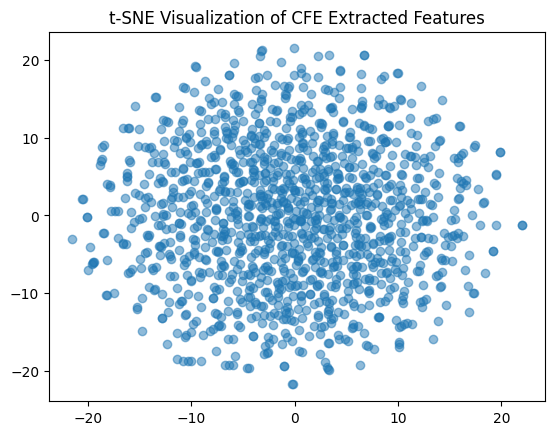

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert tensor to numpy
features = output.detach().cpu().numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# Scatter plot
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of CFE Extracted Features")
plt.show()


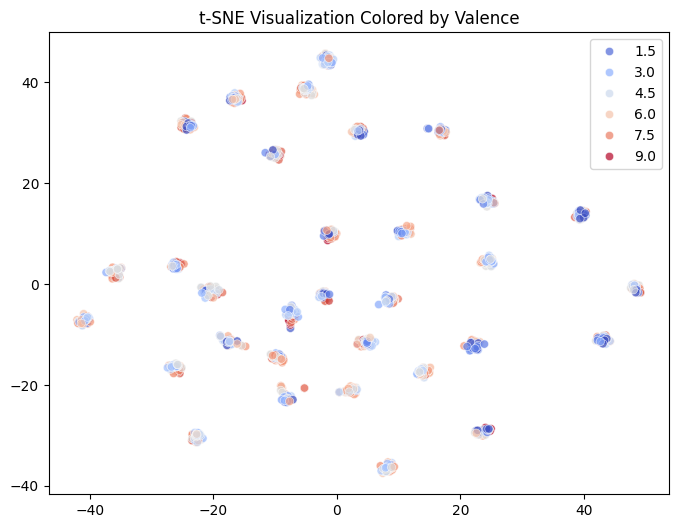

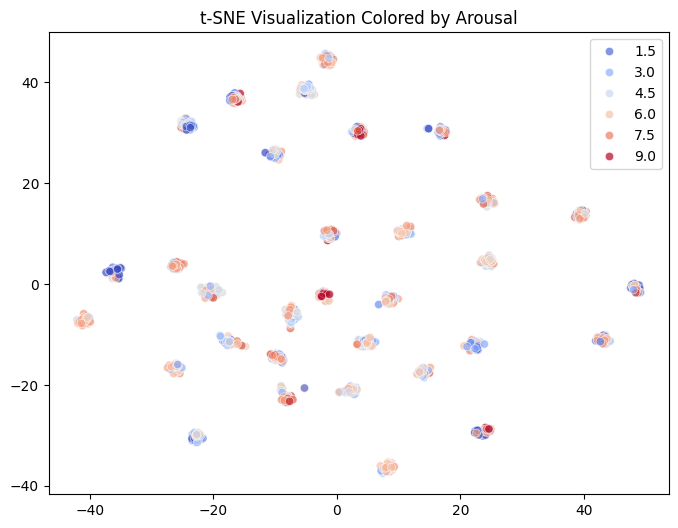

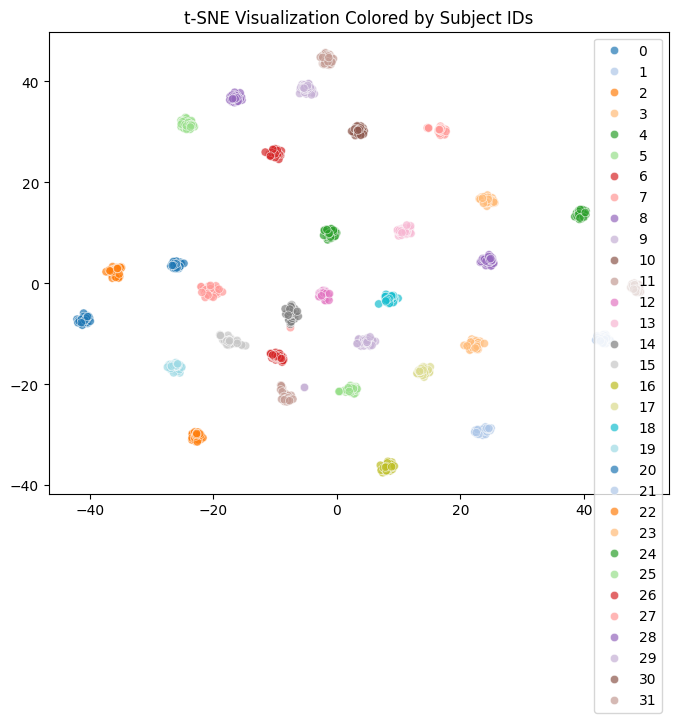

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# Assuming pca_features has shape (32, 40, 500)
reshaped_pca_features = pca_features.reshape(1280, -1)  # Shape: (1280, 500)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(reshaped_pca_features)

# Load emotion labels (valence/arousal) and subject IDs
valence_labels = subject_labels[:, :, 0].reshape(-1)  # Assuming shape (32, 40, 4), valence is first
arousal_labels = subject_labels[:, :, 1].reshape(-1)  # Arousal labels
subject_ids = np.repeat(np.arange(32), 40)  # 32 subjects, 40 trials each

# Plot t-SNE colored by Valence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=valence_labels, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization Colored by Valence")
plt.show()

# Plot t-SNE colored by Arousal
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=arousal_labels, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization Colored by Arousal")
plt.show()

# Plot t-SNE colored by Subject IDs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=subject_ids, palette="tab20", alpha=0.7)
plt.title("t-SNE Visualization Colored by Subject IDs")
plt.show()


**CONTRASTIVE LEARNING 1**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLossLcon1(nn.Module):
    def __init__(self, tau=0.1, supervised=False):
        super().__init__()
        self.tau = tau
        self.supervised = supervised

    def forward(self, q, labels=None):
        batch_size = q.shape[0]

        # Normalize feature vectors
        q = F.normalize(q, dim=-1)

        # Compute similarity matrix (cosine similarity)
        sim_matrix = torch.mm(q, q.T)  # (batch_size, batch_size)

        # Debugging: Check min/max similarity values
        # print("Sim Matrix min:", sim_matrix.min().item(), "Sim Matrix max:", sim_matrix.max().item())

        # Apply mask to remove self-similarity
        mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
        sim_matrix.masked_fill_(mask, float('-inf'))  # Prevent self-matching

        if self.supervised and labels is not None:
            # Find positive pairs based on labels
            label_mask = labels.unsqueeze(0) == labels.unsqueeze(1)  # (batch_size, batch_size)
            label_mask.fill_diagonal_(False)  # Remove self-similarity
        else:
            # In self-supervised mode, positive set is only the sample itself
            label_mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)

        # Compute exponentiated similarity matrix (temperature scaling)
        exp_sim = torch.exp(sim_matrix / self.tau)

        # Compute denominator: sum over all elements in batch
        denom = exp_sim.sum(dim=1, keepdim=True) + 1e-9  # Avoid division by zero

        # Compute numerator: sum over positive pairs only
        num = (exp_sim * label_mask).sum(dim=1, keepdim=True) + 1e-9  # Avoid log(0)

        # Compute contrastive loss
        loss = -torch.log(num / denom).mean()

        return loss


In [64]:
import torch

# Create dummy embeddings (batch_size=4, feature_dim=64)
batch_size = 4
feature_dim = 64
tau = 0.1

# Random normalized embeddings
q = torch.randn(batch_size, feature_dim)
q = torch.nn.functional.normalize(q, dim=-1)

# Random labels (for supervised contrastive loss)
labels = torch.tensor([0, 1, 0, 1])  # Two classes (0 and 1)

# Instantiate contrastive loss function
contrastive_loss = ContrastiveLossLcon1(tau=tau, supervised=True)

# Compute loss
loss_value = contrastive_loss(q, labels)

print("Contrastive Loss L_con1:", loss_value.item())


Contrastive Loss L_con1: 1.632267713546753


**Training Contrastive Learning First**

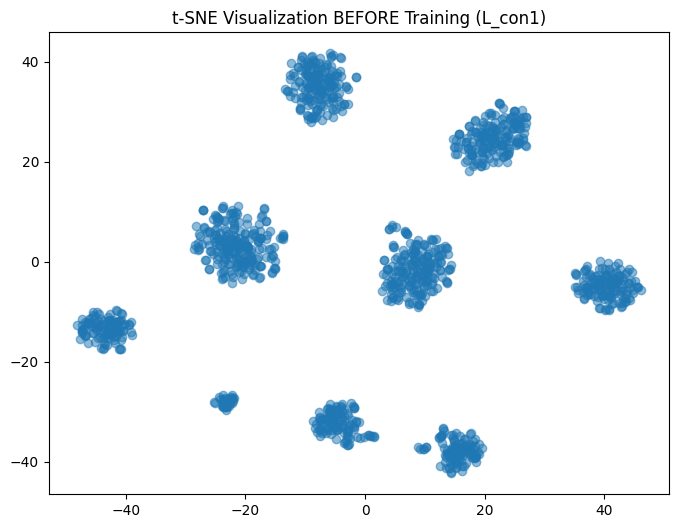

In [57]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfe = cfe.to(device)

# Convert PCA features to PyTorch tensor and RESHAPE
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32).to(device)
pca_features_tensor = pca_features_tensor.view(-1, 1000)  # Reshape to (1280, 1000)

# Extract embeddings BEFORE training
cfe.eval()
with torch.no_grad():
    cfe_features_before = cfe(pca_features_tensor).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features_before = tsne.fit_transform(cfe_features_before)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_before[:, 0], tsne_features_before[:, 1], alpha=0.5)
plt.title("t-SNE Visualization BEFORE Training (L_con1)")
plt.show()


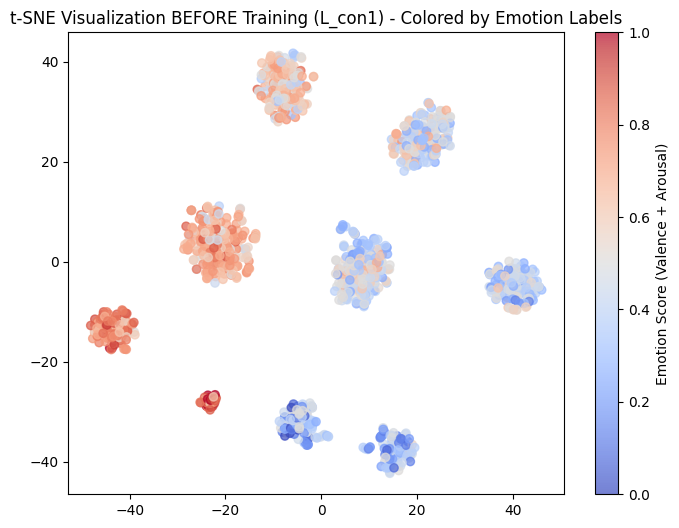

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming labels shape: (32, 40, 2) -> (valence, arousal)
# Flatten to match t-SNE input (1280,)
valence_labels = subject_labels[:, :, 0].flatten()
arousal_labels = subject_labels[:, :, 1].flatten()

# Normalize labels between 0 and 1 for color mapping
valence_norm = (valence_labels - valence_labels.min()) / (valence_labels.max() - valence_labels.min())
arousal_norm = (arousal_labels - arousal_labels.min()) / (arousal_labels.max() - arousal_labels.min())

# Combine valence & arousal for a joint color scale (averaged)
combined_labels = (valence_norm + arousal_norm) / 2

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(cfe_features_before)  # (1280, 2)

# Plot t-SNE with color-coded emotions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=combined_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Emotion Score (Valence + Arousal)")
plt.title("t-SNE Visualization BEFORE Training (L_con1) - Colored by Emotion Labels")
plt.show()


In [52]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert PCA features and labels to PyTorch tensors
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)  # (32, 40, 1000)
labels_tensor = torch.tensor(subject_labels, dtype=torch.long)  # (32, 40, 4)

# Reshape tensors for DataLoader
pca_features_tensor = pca_features_tensor.view(-1, 1000)  # (1280, 1000)
labels_tensor = labels_tensor[:, :, 0].reshape(-1)  # Convert (1280, 4) → (1280,)

# Create DataLoader
batch_size = 128
dataset = TensorDataset(pca_features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize CFE and Contrastive Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfe = CommonFeatureExtractor(input_dim=1000, output_dim=64).to(device)
contrastive_loss = ContrastiveLossLcon1(tau=0.1, supervised=True).to(device)  # Supervised mode

optimizer = optim.Adam(cfe.parameters(), lr=1e-4, weight_decay=1e-5)  # Add weight decay

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    cfe.train()
    total_loss = 0.0

    for batch in dataloader:
        eeg_data, labels = batch
        eeg_data, labels = eeg_data.to(device), labels.to(device)

        # Forward pass through CFE
        cfe_features = cfe(eeg_data)  # (batch_size, 64)

        # Compute contrastive loss
        loss = contrastive_loss(cfe_features, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(cfe.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Save trained model
torch.save(cfe.state_dict(), "cfe_trained.pth")


Epoch 1/100, Loss: 2.2001
Epoch 2/100, Loss: 2.1817
Epoch 3/100, Loss: 2.1824
Epoch 4/100, Loss: 2.1927
Epoch 5/100, Loss: 2.1575
Epoch 6/100, Loss: 2.1841
Epoch 7/100, Loss: 2.1928
Epoch 8/100, Loss: 2.1653
Epoch 9/100, Loss: 2.1680
Epoch 10/100, Loss: 2.1731
Epoch 11/100, Loss: 2.1347
Epoch 12/100, Loss: 2.1508
Epoch 13/100, Loss: 2.1424
Epoch 14/100, Loss: 2.1486
Epoch 15/100, Loss: 2.1310
Epoch 16/100, Loss: 2.1269
Epoch 17/100, Loss: 2.1632
Epoch 18/100, Loss: 2.1214
Epoch 19/100, Loss: 2.1107
Epoch 20/100, Loss: 2.1158
Epoch 21/100, Loss: 2.1015
Epoch 22/100, Loss: 2.0921
Epoch 23/100, Loss: 2.1255
Epoch 24/100, Loss: 2.1053
Epoch 25/100, Loss: 2.0672
Epoch 26/100, Loss: 2.0222
Epoch 27/100, Loss: 2.0586
Epoch 28/100, Loss: 2.0380
Epoch 29/100, Loss: 1.9725
Epoch 30/100, Loss: 1.9684
Epoch 31/100, Loss: 1.9820
Epoch 32/100, Loss: 1.9295
Epoch 33/100, Loss: 1.9519
Epoch 34/100, Loss: 1.8828
Epoch 35/100, Loss: 1.8837
Epoch 36/100, Loss: 1.8746
Epoch 37/100, Loss: 1.8531
Epoch 38/1

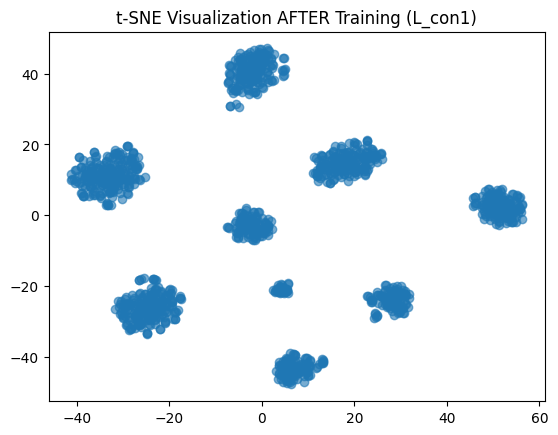

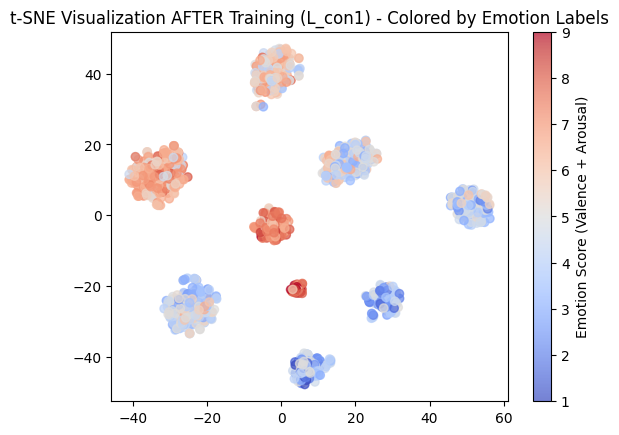

In [60]:
# Load trained model
cfe.load_state_dict(torch.load("cfe_trained.pth"))
cfe.eval()  # Set to evaluation mode

# Extract learned features after training
with torch.no_grad():
    post_training_features = cfe(pca_features_tensor.to(device))  # (1280, 64)
    post_training_features = post_training_features.cpu().numpy()  # Convert to NumPy


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
post_training_tsne = tsne.fit_transform(post_training_features)

# Scatter plot
plt.scatter(post_training_tsne[:, 0], post_training_tsne[:, 1], alpha=0.6)
plt.title("t-SNE Visualization AFTER Training (L_con1)")
plt.show()


import numpy as np

# Normalize emotion labels to [0,1]
emotion_scores = (valence_labels + arousal_labels) / 2  # Shape: (1280,)

plt.scatter(post_training_tsne[:, 0], post_training_tsne[:, 1], c=emotion_scores, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Emotion Score (Valence + Arousal)")
plt.title("t-SNE Visualization AFTER Training (L_con1) - Colored by Emotion Labels")
plt.show()


In [61]:
all_features = []
all_labels = []

cfe.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in dataloader:
        eeg_data, labels = batch
        eeg_data, labels = eeg_data.to(device), labels.to(device)
        
        # Extract features from trained model
        features = cfe(eeg_data)  
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Convert to numpy
all_features = torch.cat(all_features).numpy()
all_labels = torch.cat(all_labels).numpy()
np.save("post_training_features.npy", all_features)
np.save("post_training_labels.npy", all_labels)


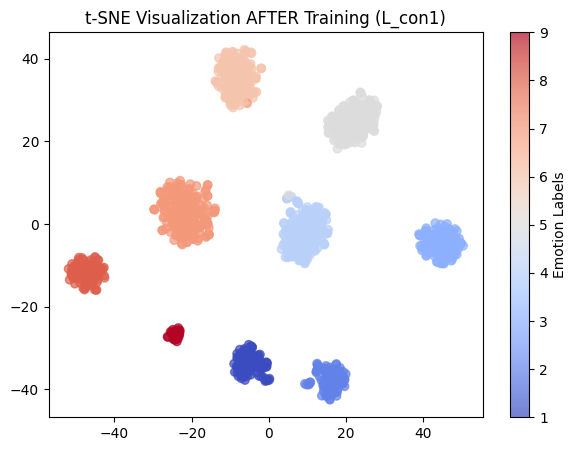

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved features
features = np.load("post_training_features.npy")
labels = np.load("post_training_labels.npy")

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Visualization
plt.figure(figsize=(7, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Emotion Labels")
plt.title("t-SNE Visualization AFTER Training (L_con1)")
plt.show()
